In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 7.2MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 296kB 7.2MB/s 


In [2]:
!wget https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1 -O erm.zip

--2021-03-08 08:51:13--  https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/qrdswgzv63o3opg/datasetCorregido.zip [following]
--2021-03-08 08:51:13--  https://www.dropbox.com/s/dl/qrdswgzv63o3opg/datasetCorregido.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd00d1b72b058fdb36c9eeed1ef.dl.dropboxusercontent.com/cd/0/get/BKSVuxVPsNx6fAW75x6sQ1IhkFuojUzAj3IWAH4ggjk24_mJTCj69alsAC1kbhnuAOiI25uqtf1MS9Rq_frFvrNZRYUQjUezMq6fQMvXX6JU2Ugb_nFZf8ZFBAWVByanSXamLOsZgsHXLQkxwCWFkLco/file?dl=1# [following]
--2021-03-08 08:51:13--  https://ucd00d1b72b058fdb36c9eeed1ef.dl.dropboxusercontent.com/cd/0/get/BKSVuxVPsNx6fAW75x6sQ1IhkFuojUzAj3IWAH4ggjk24_mJTCj69alsAC1kbhnu

In [3]:
!unzip erm.zip

Archive:  erm.zip
   creating: datasetCorregido/
   creating: datasetCorregido/train/
   creating: datasetCorregido/train/no/
  inflating: datasetCorregido/train/no/anonymized_482127.jpg  
  inflating: datasetCorregido/train/no/anonymized_174749.jpg  
  inflating: datasetCorregido/train/no/anonymized_734047.jpg  
  inflating: datasetCorregido/train/no/anonymized_581767.jpg  
  inflating: datasetCorregido/train/no/anonymized_1400777.jpg  
  inflating: datasetCorregido/train/no/anonymized_347431.jpg  
  inflating: datasetCorregido/train/no/anonymized_626433.jpg  
  inflating: datasetCorregido/train/no/anonymized_1372303.jpg  
  inflating: datasetCorregido/train/no/anonymized_1324599.jpg  
  inflating: datasetCorregido/train/no/anonymized_196853.jpg  
  inflating: datasetCorregido/train/no/anonymized_687000.jpg  
  inflating: datasetCorregido/train/no/anonymized_504041.jpg  
  inflating: datasetCorregido/train/no/anonymized_1414333.jpg  
  inflating: datasetCorregido/train/no/anonymized_3

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('datasetCorregido/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=360,max_warp=0,max_zoom=1.1,
                      max_lighting=0.1,p_lighting=0.5), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=32)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18')
]

In [14]:
modelo='resnet101d'

## Ranger

In [10]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [ ]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

Pretrained model URL is invalid, using random initialization.


SuggestedLRs(lr_min=0.06309573650360108, lr_steep=9.12010818865383e-07)

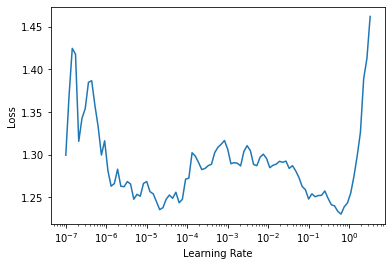

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.304640,0.918186,0.522936,0.540682,0.600583,01:57
1,1.239081,0.890051,0.515290,0.531100,0.647230,01:55


Better model found at epoch 0 with valid_loss value: 0.9181863069534302.


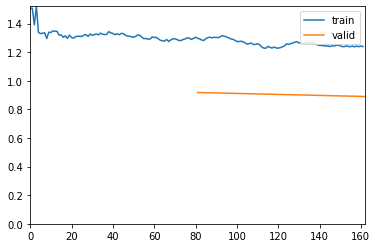

Better model found at epoch 1 with valid_loss value: 0.8900514841079712.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.226948,0.838023,0.510703,0.530026,0.591837,02:27
1,1.206959,0.815832,0.504587,0.527221,0.536443,02:25
2,1.149119,0.821334,0.515290,0.534392,0.588921,02:25
3,1.158872,0.817666,0.530581,0.541475,0.685131,02:26
4,1.156383,0.823721,0.529052,0.535497,0.769679,02:25


Better model found at epoch 0 with valid_loss value: 0.83802330493927.


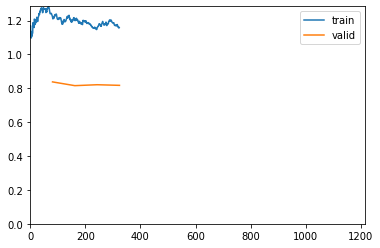

Better model found at epoch 1 with valid_loss value: 0.81583172082901.
No improvement since epoch 1: early stopping


In [ ]:
learn.fine_tune(15,freeze_epochs=2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

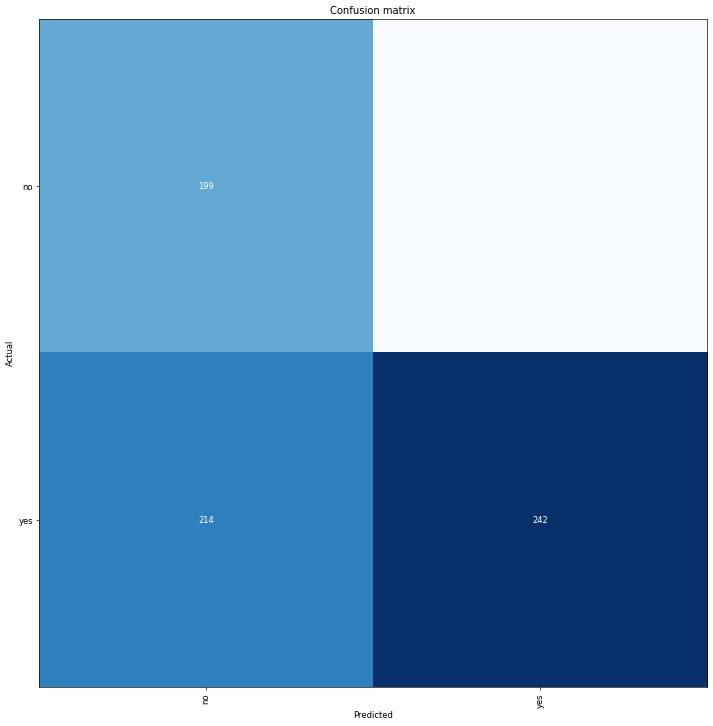

In [ ]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5464683771133423.


(#4) [0.7881250381469727,0.5464683771133423,0.6142131979695431,0.5307017543859649]

## Faltten

In [ ]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()])

Pretrained model URL is invalid, using random initialization.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.185474,0.793702,0.518349,0.539773,0.553936,01:54
1,0.951924,0.729958,0.518349,0.560870,0.376093,01:54


Better model found at epoch 0 with valid_loss value: 0.7937015295028687.


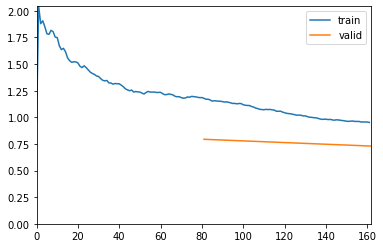

Better model found at epoch 1 with valid_loss value: 0.7299582362174988.


In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=1.5848931980144698e-06)

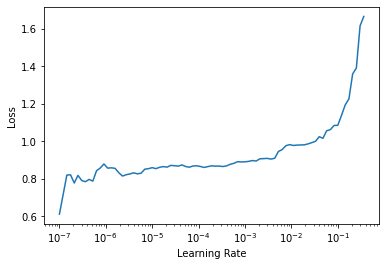

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.047673,0.857621,0.477064,0.501916,0.381924,02:24
1,0.953926,0.961900,0.498471,0.520436,0.556851,02:24
2,0.986152,1.194117,0.518349,0.523649,0.903790,02:24
3,1.009471,7.008312,0.525994,0.525268,1.000000,02:24


Better model found at epoch 0 with valid_loss value: 0.8576209545135498.


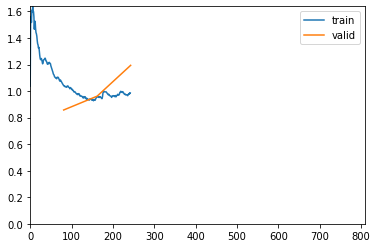

No improvement since epoch 0: early stopping


In [ ]:
learn.fit_flat_cos(10,lr=1e-2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

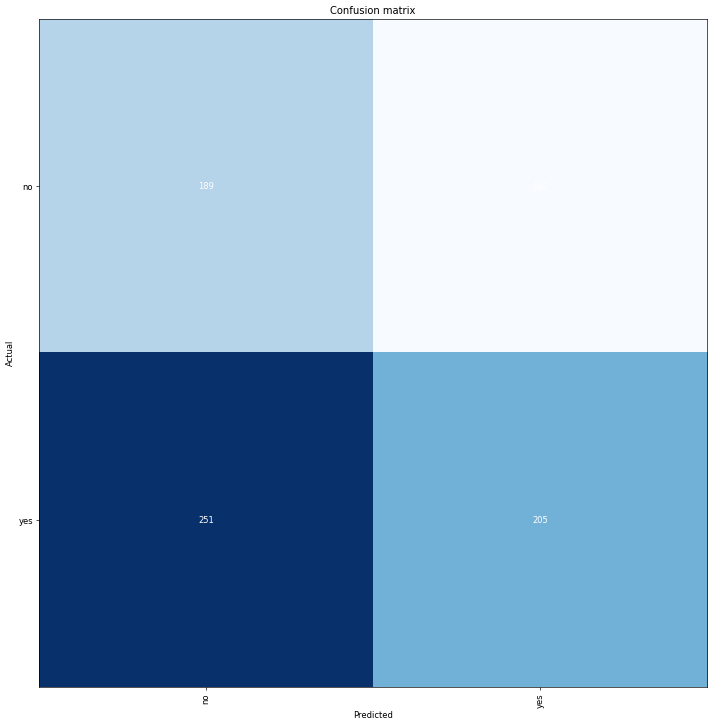

In [ ]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.4882279932498932.


(#4) [0.8668902516365051,0.4882279932498932,0.55858310626703,0.44956140350877194]

## LabelSmoothing

In [ ]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

Pretrained model URL is invalid, using random initialization.


SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=2.2908675418875646e-06)

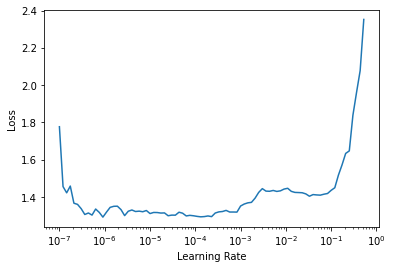

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.293761,1.344008,0.506116,0.534722,0.448980,01:54
1,1.057605,0.781664,0.516820,0.570681,0.317784,01:54


Better model found at epoch 0 with valid_loss value: 1.3440076112747192.


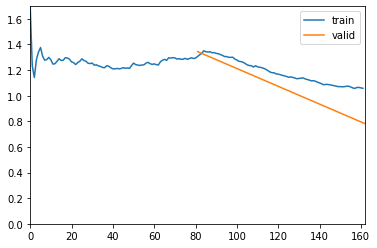

Better model found at epoch 1 with valid_loss value: 0.7816637754440308.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.871636,0.712960,0.542813,0.547826,0.734694,02:25
1,0.820858,0.727410,0.539755,0.543033,0.772595,02:25
2,0.830740,0.728229,0.529052,0.593583,0.323615,02:25
3,0.811860,0.703980,0.558104,0.576271,0.594752,02:25
4,0.779511,0.726198,0.515290,0.522414,0.883382,02:25
5,0.733805,0.703953,0.542813,0.542636,0.816327,02:25
6,0.738729,0.715643,0.536697,0.560241,0.542274,02:25
7,0.721845,0.708229,0.501529,0.585859,0.169096,02:25
8,0.714647,0.689631,0.567278,0.582873,0.615160,02:25
9,0.705558,0.699044,0.556575,0.625592,0.384840,02:25


Better model found at epoch 0 with valid_loss value: 0.7129597067832947.


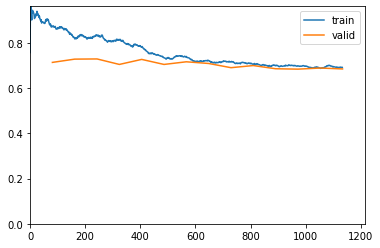

Better model found at epoch 3 with valid_loss value: 0.7039798498153687.
Better model found at epoch 5 with valid_loss value: 0.7039531469345093.
Better model found at epoch 8 with valid_loss value: 0.689630925655365.
Better model found at epoch 10 with valid_loss value: 0.6849275827407837.
Better model found at epoch 11 with valid_loss value: 0.6831681728363037.
No improvement since epoch 11: early stopping


In [ ]:
learn.fine_tune(15,freeze_epochs=2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

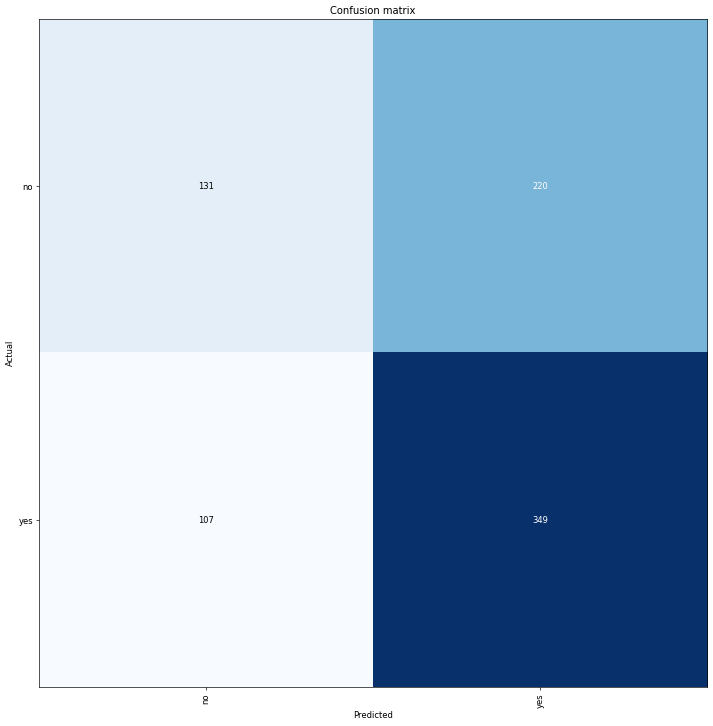

In [ ]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5947955250740051.


(#4) [0.6770003437995911,0.5947955250740051,0.6133567662565905,0.7653508771929824]

## MixUp

In [11]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [ ]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

Pretrained model URL is invalid, using random initialization.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.319347,1.227561,0.527523,0.533333,0.793003,01:55
1,1.106326,0.760714,0.507645,0.560694,0.282799,01:55


Better model found at epoch 0 with valid_loss value: 1.227561116218567.


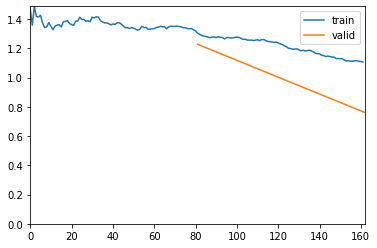

Better model found at epoch 1 with valid_loss value: 0.7607136964797974.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.881729,0.896908,0.467890,0.448980,0.064140,02:25
1,0.853135,0.902101,0.490826,0.559524,0.137026,02:25
2,0.837582,0.698273,0.524465,0.548780,0.524781,02:25
3,0.806674,0.723061,0.500000,0.548780,0.262391,02:25
4,0.769979,0.916349,0.483180,0.534247,0.113703,02:25
5,0.740413,0.809753,0.483180,0.560976,0.067055,02:25


Better model found at epoch 0 with valid_loss value: 0.8969078660011292.


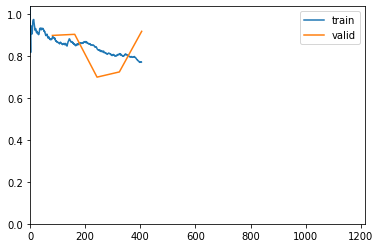

Better model found at epoch 2 with valid_loss value: 0.6982726454734802.
No improvement since epoch 2: early stopping


In [ ]:
learn.fine_tune(15,freeze_epochs=2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

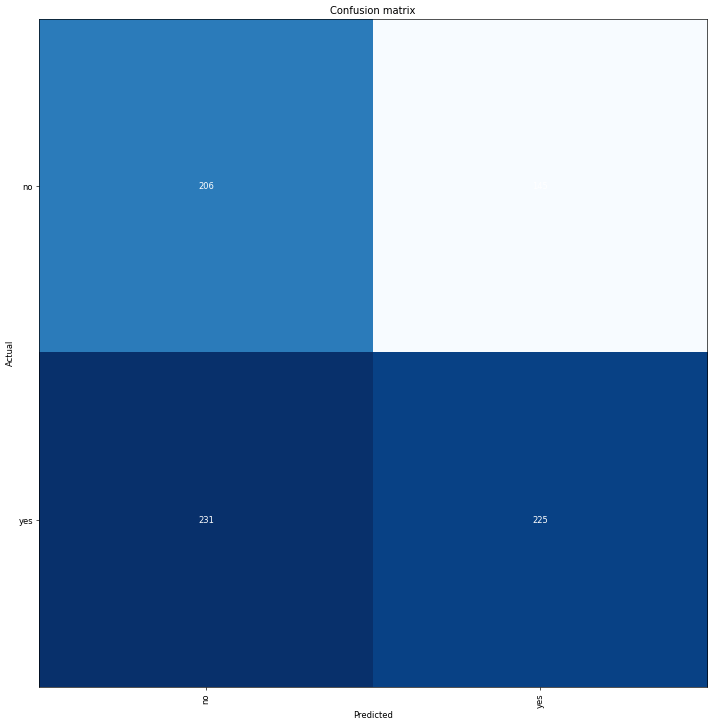

In [ ]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5340768098831177.


(#4) [0.6937233209609985,0.5340768098831177,0.6081081081081081,0.4934210526315789]

## Ranger + Flat cosin Anneal

In [ ]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

Pretrained model URL is invalid, using random initialization.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.261309,0.832044,0.525994,0.550459,0.524781,01:55
1,1.213195,0.819702,0.518349,0.543210,0.513120,01:55


Better model found at epoch 0 with valid_loss value: 0.8320439457893372.


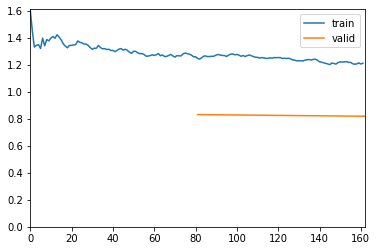

Better model found at epoch 1 with valid_loss value: 0.8197024464607239.


In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=1.3182567499825382e-06)

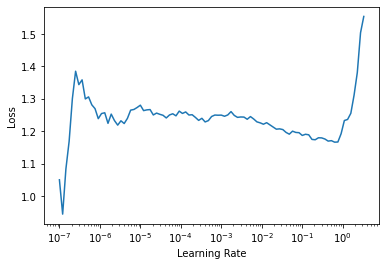

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.247610,1.502130,0.472477,0.375000,0.008746,02:25
1,1.049893,0.883481,0.516820,0.522689,0.906706,02:26
2,0.953700,0.767629,0.532110,0.542529,0.688047,02:26
3,0.894695,0.762972,0.522936,0.529981,0.798834,02:26
4,0.811864,0.703384,0.536697,0.559524,0.548105,02:26
5,0.768305,0.694330,0.551988,0.577640,0.542274,02:26
6,0.743131,0.805679,0.483180,0.592593,0.046647,02:26
7,0.736597,0.717098,0.487768,0.544444,0.142857,02:26
8,0.724440,0.697399,0.533639,0.593137,0.352770,02:26


Better model found at epoch 0 with valid_loss value: 1.5021299123764038.


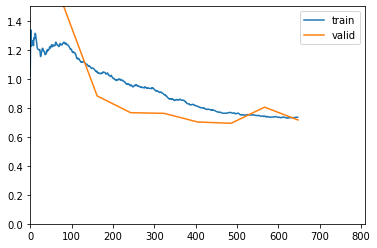

Better model found at epoch 1 with valid_loss value: 0.883480966091156.
Better model found at epoch 2 with valid_loss value: 0.7676288485527039.
Better model found at epoch 3 with valid_loss value: 0.7629722356796265.
Better model found at epoch 4 with valid_loss value: 0.7033836841583252.
Better model found at epoch 5 with valid_loss value: 0.6943298578262329.
No improvement since epoch 5: early stopping


In [ ]:
learn.fit_flat_cos(10,lr=1e-2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5142503380775452.


(#4) [0.7017737627029419,0.5142503380775452,0.5792079207920792,0.5131578947368421]

## Ranger+Flar Cossin Anneal+LabelSmoothing

In [ ]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

Pretrained model URL is invalid, using random initialization.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.262989,0.891916,0.527523,0.587629,0.332362,01:55
1,1.212123,0.859757,0.500000,0.540404,0.311953,01:55


Better model found at epoch 0 with valid_loss value: 0.8919160962104797.


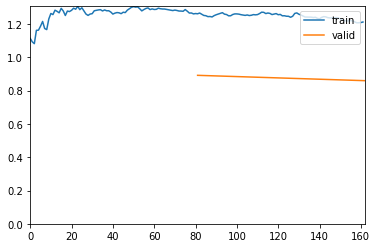

Better model found at epoch 1 with valid_loss value: 0.8597574234008789.


In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=8.31763736641733e-07, lr_steep=6.918309736647643e-06)

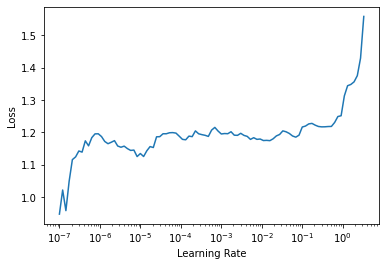

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.211380,0.834842,0.515290,0.529954,0.670554,02:26
1,1.085173,0.773661,0.506116,0.523041,0.661808,02:26
2,0.965842,0.750466,0.518349,0.530043,0.720117,02:26
3,0.888151,0.719129,0.524465,0.539409,0.638484,02:26
4,0.808986,0.712766,0.492355,0.556701,0.157434,02:26
5,0.769124,0.694756,0.532110,0.576763,0.405248,02:25
6,0.738998,0.699445,0.521407,0.551020,0.472303,02:25
7,0.726771,0.683933,0.567278,0.559761,0.819242,02:26
8,0.722060,0.694090,0.530581,0.546875,0.612245,02:26
9,0.716128,0.695432,0.556575,0.556025,0.766764,02:25


Better model found at epoch 0 with valid_loss value: 0.8348419666290283.


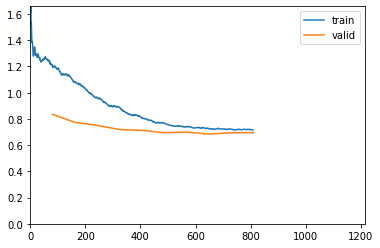

Better model found at epoch 1 with valid_loss value: 0.7736614942550659.
Better model found at epoch 2 with valid_loss value: 0.7504664063453674.
Better model found at epoch 3 with valid_loss value: 0.7191287875175476.
Better model found at epoch 4 with valid_loss value: 0.7127662301063538.
Better model found at epoch 5 with valid_loss value: 0.6947561502456665.
Better model found at epoch 7 with valid_loss value: 0.6839330792427063.
No improvement since epoch 7: early stopping


In [ ]:
learn.fit_flat_cos(15,lr=1e-2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5687732100486755.


(#4) [0.6828992962837219,0.5687732100486755,0.5885245901639344,0.7872807017543859]

## Ranger +Flat + Label + MixUp

In [ ]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

Pretrained model URL is invalid, using random initialization.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.322886,0.820692,0.519878,0.505952,0.534591,01:55
1,1.212473,0.829842,0.518349,0.503722,0.638365,01:55


Better model found at epoch 0 with valid_loss value: 0.8206915259361267.


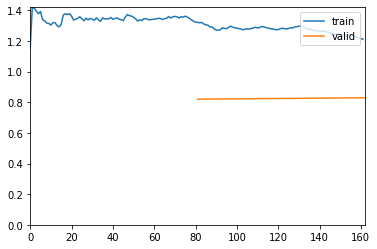

In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.239161,0.980520,0.472477,0.472165,0.720126,02:25
1,1.108874,0.785938,0.486239,0.463115,0.355346,02:25
2,0.997597,0.787482,0.516820,0.502222,0.710692,02:25
3,0.884411,0.748331,0.487768,0.483235,0.770440,02:25
4,0.813547,0.708770,0.518349,0.505017,0.474843,02:25
5,0.768930,0.707962,0.522936,0.515957,0.305031,02:25
6,0.737695,0.704327,0.487768,0.480186,0.647799,02:25
7,0.729612,0.708630,0.512232,0.497326,0.292453,02:25
8,0.719366,0.712542,0.496942,0.480287,0.421384,02:25
9,0.715432,0.702190,0.503058,0.492408,0.713836,02:25


Better model found at epoch 0 with valid_loss value: 0.9805197715759277.


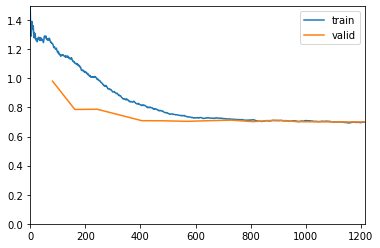

Better model found at epoch 1 with valid_loss value: 0.7859377861022949.
Better model found at epoch 3 with valid_loss value: 0.7483306527137756.
Better model found at epoch 4 with valid_loss value: 0.708770215511322.
Better model found at epoch 5 with valid_loss value: 0.7079620957374573.
Better model found at epoch 6 with valid_loss value: 0.7043273448944092.
Better model found at epoch 9 with valid_loss value: 0.7021899223327637.
Better model found at epoch 11 with valid_loss value: 0.7017973065376282.
Better model found at epoch 12 with valid_loss value: 0.7009469866752625.
Better model found at epoch 13 with valid_loss value: 0.7002734541893005.
Better model found at epoch 14 with valid_loss value: 0.7001578211784363.


In [ ]:
learn.fit_flat_cos(15,lr=1e-2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

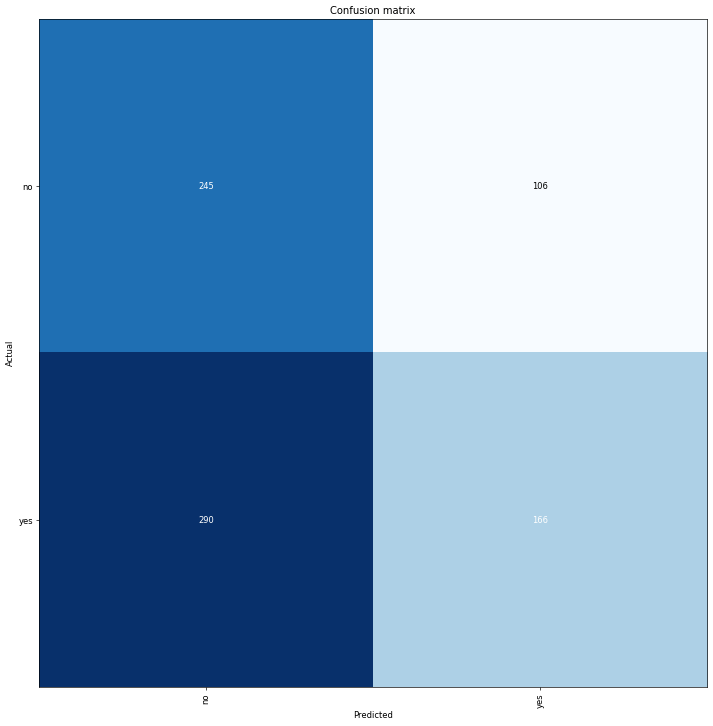

In [ ]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5092936754226685.


(#4) [0.6996525526046753,0.5092936754226685,0.6102941176470589,0.36403508771929827]

## Ranger + Flat + MixUp

In [ ]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [ ]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

Pretrained model URL is invalid, using random initialization.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.188534,0.890248,0.486239,0.464844,0.374214,01:55
1,1.173176,0.881197,0.489297,0.471429,0.415094,01:55


Better model found at epoch 0 with valid_loss value: 0.8902480602264404.


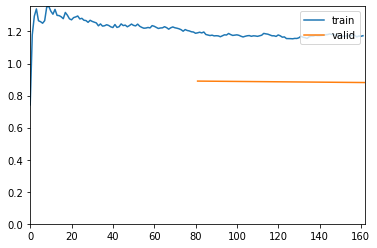

Better model found at epoch 1 with valid_loss value: 0.8811968564987183.


In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.148185,0.844518,0.510703,0.498214,0.877358,02:25
1,1.091217,0.749059,0.524465,0.514523,0.389937,02:25
2,0.954576,0.793365,0.461774,0.430328,0.330189,02:25
3,0.876568,0.725643,0.493884,0.473029,0.358491,02:25
4,0.800481,0.741143,0.460245,0.457627,0.594340,02:25
5,0.762906,0.724263,0.506116,0.480315,0.191824,02:25
6,0.742752,0.706933,0.515290,0.502463,0.320755,02:25
7,0.731928,0.701005,0.507645,0.488636,0.270440,02:25
8,0.720142,0.708895,0.518349,0.502836,0.836478,02:25
9,0.714882,0.709472,0.506116,0.459016,0.088050,02:25


Better model found at epoch 0 with valid_loss value: 0.8445180058479309.


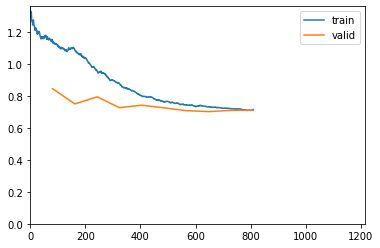

Better model found at epoch 1 with valid_loss value: 0.7490592002868652.
Better model found at epoch 3 with valid_loss value: 0.7256430387496948.
Better model found at epoch 5 with valid_loss value: 0.7242629528045654.
Better model found at epoch 6 with valid_loss value: 0.706933319568634.
Better model found at epoch 7 with valid_loss value: 0.7010051608085632.
No improvement since epoch 7: early stopping


In [ ]:
learn.fit_flat_cos(15,lr=1e-2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5043370723724365.


(#4) [0.7208651900291443,0.5043370723724365,0.6129032258064516,0.3333333333333333]

## Ranger + MixUp

In [ ]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [ ]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

Pretrained model URL is invalid, using random initialization.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.298003,0.940246,0.510703,0.498069,0.811321,01:55
1,1.288417,0.869105,0.512232,0.498915,0.723270,01:55


Better model found at epoch 0 with valid_loss value: 0.9402455687522888.


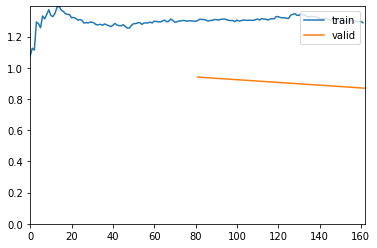

Better model found at epoch 1 with valid_loss value: 0.8691051602363586.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.226986,0.826390,0.510703,0.497596,0.650943,02:25
1,1.199938,0.843597,0.544343,0.525253,0.654088,02:25
2,1.237300,0.805558,0.518349,0.507317,0.327044,02:25
3,1.194841,0.808312,0.538226,0.523952,0.550314,02:25
4,1.112379,0.786045,0.541284,0.536885,0.411950,02:25
5,1.115523,0.797880,0.524465,0.520000,0.286164,02:25
6,1.150794,0.828629,0.506116,0.485549,0.264151,02:25
7,1.126188,0.768989,0.527523,0.515571,0.468553,02:25
8,1.123476,0.788057,0.513761,0.500000,0.330189,02:25
9,1.077357,0.792701,0.518349,0.505155,0.462264,02:25


Better model found at epoch 0 with valid_loss value: 0.8263904452323914.


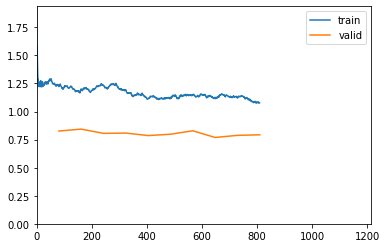

Better model found at epoch 2 with valid_loss value: 0.8055581450462341.
Better model found at epoch 4 with valid_loss value: 0.7860445976257324.
Better model found at epoch 7 with valid_loss value: 0.7689887285232544.
No improvement since epoch 7: early stopping


In [ ]:
learn.fine_tune(15,freeze_epochs=2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5154894590377808.


(#4) [0.7780410647392273,0.5154894590377808,0.5931232091690545,0.45394736842105265]

## Faltten + MixUp

In [ ]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

Pretrained model URL is invalid, using random initialization.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.134201,0.781604,0.538226,0.565574,0.216981,01:54
1,0.936593,0.819608,0.516820,0.562500,0.028302,01:54


Better model found at epoch 0 with valid_loss value: 0.7816036343574524.


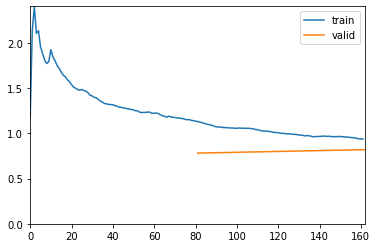

In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.024463,1.514033,0.527523,0.604651,0.081761,02:24
1,1.004125,0.881011,0.500000,0.448276,0.122642,02:24
2,0.943115,0.719807,0.498471,0.464286,0.204403,02:24
3,0.945847,1.061064,0.519878,0.509346,0.342767,02:24
4,0.906425,0.714440,0.512232,0.496350,0.213836,02:24
5,0.946712,6.120796,0.486239,0.486239,1.000000,02:24
6,0.873203,3.273196,0.519878,0.512821,0.251572,02:24
7,0.838655,0.716185,0.487768,0.459716,0.305031,02:24


Better model found at epoch 0 with valid_loss value: 1.5140327215194702.


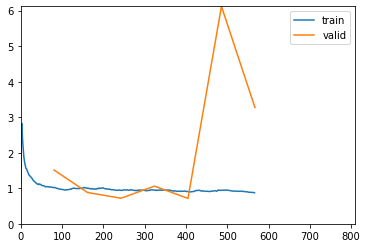

Better model found at epoch 1 with valid_loss value: 0.8810107707977295.
Better model found at epoch 2 with valid_loss value: 0.7198067307472229.
Better model found at epoch 4 with valid_loss value: 0.7144402265548706.
No improvement since epoch 4: early stopping


In [ ]:
learn.fit_flat_cos(10,lr=1e-2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.4882279932498932.


(#4) [0.7129001617431641,0.4882279932498932,0.6335403726708074,0.2236842105263158]

## Ranger + Label

In [ ]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [ ]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

Pretrained model URL is invalid, using random initialization.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.288858,0.926941,0.472477,0.446215,0.352201,01:54
1,1.257895,0.932230,0.481651,0.432258,0.210692,01:54


Better model found at epoch 0 with valid_loss value: 0.9269412755966187.


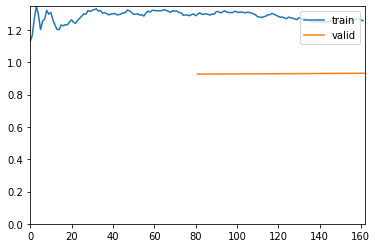

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.263464,0.929253,0.487768,0.459716,0.305031,02:25
1,1.288000,0.887113,0.457187,0.430189,0.358491,02:25
2,1.240465,0.862220,0.478593,0.455253,0.367925,02:25
3,1.222087,0.867323,0.492355,0.464646,0.289308,02:25
4,1.184158,0.900677,0.489297,0.433333,0.163522,02:25
5,1.166569,0.834047,0.484709,0.453659,0.292453,02:25
6,1.143002,0.840000,0.492355,0.457831,0.238994,02:25
7,1.138933,0.814095,0.490826,0.471483,0.389937,02:25
8,1.113942,0.884823,0.515290,0.507692,0.103774,02:25
9,1.091174,0.819453,0.498471,0.467532,0.226415,02:24


Better model found at epoch 0 with valid_loss value: 0.9292534589767456.


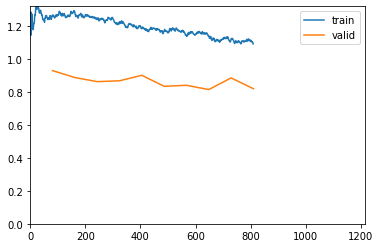

Better model found at epoch 1 with valid_loss value: 0.8871131539344788.
Better model found at epoch 2 with valid_loss value: 0.8622203469276428.
Better model found at epoch 5 with valid_loss value: 0.8340467214584351.
Better model found at epoch 7 with valid_loss value: 0.8140950202941895.
No improvement since epoch 7: early stopping


In [ ]:
learn.fine_tune(15,freeze_epochs=2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5179677605628967.


(#4) [0.7699837684631348,0.5179677605628967,0.6,0.4407894736842105]

## Faltten + Label

In [ ]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

Pretrained model URL is invalid, using random initialization.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.117514,0.768076,0.500000,0.482490,0.389937,01:53
1,0.956196,0.707569,0.538226,0.531250,0.427673,01:53


Better model found at epoch 0 with valid_loss value: 0.7680764198303223.


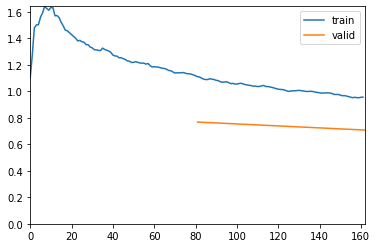

Better model found at epoch 1 with valid_loss value: 0.7075692415237427.


In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=1.0964782268274575e-05, lr_steep=1.2022644114040304e-05)

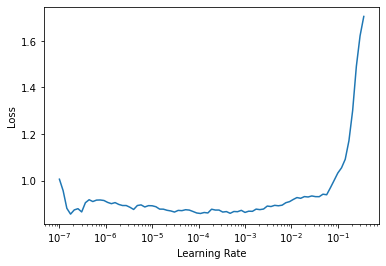

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.980360,3.284317,0.513761,0.000000,0.000000,02:23
1,0.926198,0.901221,0.487768,0.486983,1.000000,02:23
2,0.923619,0.772945,0.496942,0.490265,0.871069,02:23
3,0.863460,0.806588,0.486239,0.486239,1.000000,02:23
4,0.891973,0.778051,0.518349,0.516129,0.150943,02:22
5,0.878330,0.715595,0.515290,0.600000,0.009434,02:23
6,0.831307,1.713950,0.513761,0.000000,0.000000,02:23
7,0.853450,0.809404,0.500000,0.492586,0.940252,02:23
8,0.814597,1.573783,0.513761,0.000000,0.000000,02:22


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 3.2843167781829834.


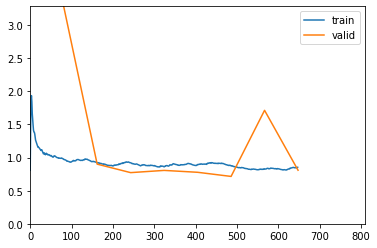

Better model found at epoch 1 with valid_loss value: 0.9012205600738525.
Better model found at epoch 2 with valid_loss value: 0.7729445695877075.
Better model found at epoch 5 with valid_loss value: 0.7155951857566833.
No improvement since epoch 5: early stopping


In [ ]:
learn.fit_flat_cos(10,lr=1e-2)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.43246591091156006.


(#4) [0.7444471716880798,0.43246591091156006,0.0,0.0]

## Label + MixUp

In [15]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet101d_ra2-2803ffab.pth" to /root/.cache/torch/hub/checkpoints/resnet101d_ra2-2803ffab.pth


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.306602,1.078779,0.551988,0.580128,0.527697,01:01
1,1.115146,0.767158,0.577982,0.573304,0.763848,00:59


Better model found at epoch 0 with valid_loss value: 1.0787792205810547.


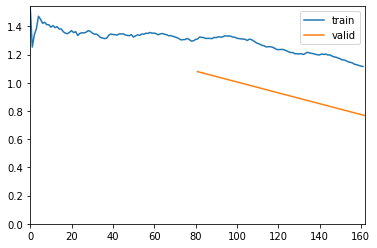

Better model found at epoch 1 with valid_loss value: 0.7671580910682678.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.795794,0.704525,0.568807,0.615970,0.472303,01:16
1,0.751370,0.696439,0.581040,0.666667,0.402332,01:15
2,0.726616,0.670944,0.600917,0.604061,0.693878,01:15
3,0.705532,0.687140,0.562691,0.567696,0.696793,01:16
4,0.696173,0.673223,0.605505,0.711443,0.416910,01:15
5,0.688891,0.664413,0.585627,0.594737,0.658892,01:15
6,0.676434,0.671141,0.599388,0.652830,0.504373,01:15
7,0.668821,0.645290,0.648318,0.656510,0.690962,01:16
8,0.666295,0.658654,0.617737,0.699571,0.475219,01:16
9,0.657320,0.649534,0.636086,0.692308,0.551020,01:16


Better model found at epoch 0 with valid_loss value: 0.7045250535011292.


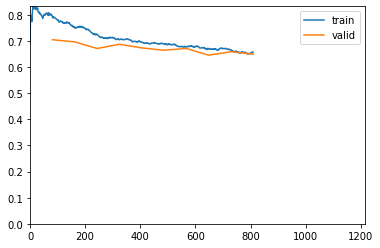

Better model found at epoch 1 with valid_loss value: 0.6964388489723206.
Better model found at epoch 2 with valid_loss value: 0.6709440350532532.
Better model found at epoch 5 with valid_loss value: 0.6644132137298584.
Better model found at epoch 7 with valid_loss value: 0.6452900767326355.
No improvement since epoch 7: early stopping


In [16]:
learn.fine_tune(15,freeze_epochs=2)

In [17]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [18]:
learn.dls = dlsTest

In [19]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6864931583404541.


(#4) [0.61406409740448,0.6864931583404541,0.7291196388261851,0.7083333333333334]